# Netflix Customer Churn Analysis and Prediction

### Data Scientist: Nikita Ramsey

### Project overview:

This project explores customer churn behavior for a Netflix-like streaming service, with the goal of identifying which user behaviors and account attributes are most predictive of churn. Rather than focusing on a single model or metric, the emphasis is on understanding the data, evaluating multiple modeling approaches, and diagnosing where and why models succeed or fail.

The workflow follows an end-to-end data science process: exploratory analysis, feature engineering, statistical feature selection, model comparison, tuning, and post-model error analysis.

### About the Data:

This dataset contains synthetic data simulating customer behavior for a Netflix-like video streaming service. It was programmatically retrieved using the Kagglehub package and contains 5000 records and 14 attributes including:

*  customer_id (str): unique identifier for each customer
*  age (int): age of each customer
*  gender (str): gender of each customer (includes 'female', 'male', and 'other')
*  subscription_type (str): subscription tier for each customer (includes 'basic', 'standard', and 'premium')
*  watch_hours (float): number of hours watched by each customer (unsure of cadence [weekly or monthly]; ranges from .01 - 110)
*  last_login_days (int): number of days since last login (ranges from 0-60)
*  payment_method (str): payment type used by each customer (includes 'debit card', 'crypto', 'paypal', 'credit card', and 'gift card')
*  number_of_profiles (int): number of profiles associated with each customer (ranges from 1-5)
*  avg_watch_time_per_day (float): avg time each customer uses the service per day
*  favorite_genre (str): favorite genre of each customer (includes 'drama', 'action', 'documentary', 'comedy', 'romance', 'horror', 'sci-fi')
*  region (str): geographic region of each customer (includes 'Africa', 'Europe', 'Asia', 'Oceania', 'South America', and 'North America')
*  device (str): type of device used by each customer (includes 'tv', 'mobile' and 'laptop')
*  monthly_fee (float): price of subscription paid by each customer (includes 8.99, 13.99 and 17.99)
*  churned (int): whether the customer discontinued service or not (includes 0 for continued, 1 for discontinued)

### Install dependencies

In [1]:
%pip install mlxtend kagglehub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import shutil
import kagglehub
from pathlib import Path
import scipy.stats as stats
from scipy import sparse
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_auc_score, roc_curve, recall_score, accuracy_score, precision_score, f1_score  
from sklearn.pipeline import Pipeline, FunctionTransformer, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

### Load and sanity-check the data

In [3]:
"""# Download latest version
path = kagglehub.dataset_download("abdulwadood11220/netflix-customer-churn-dataset")

print("Path to dataset files:", path)"""

'# Download latest version\npath = kagglehub.dataset_download("abdulwadood11220/netflix-customer-churn-dataset")\n\nprint("Path to dataset files:", path)'

In [4]:
# retrieve cache location since hit max retries
kaggle_cache_csv = Path(
    r"C:\Users\peace\.cache\kagglehub\datasets\abdulwadood11220"
    r"\netflix-customer-churn-dataset\versions\1\netflix_customer_churn.csv")

In [5]:
# make project data folder
project_data_dir = Path("data")
project_data_dir.mkdir(exist_ok=True)

destination = project_data_dir / "netflix_customer_churn.csv"
shutil.copy(kaggle_cache_csv, destination)
print(f"Copied dataset to: {destination.resolve()}")

Copied dataset to: C:\Users\peace\OneDrive\Documents\GitHub\Machine Learning Projects\Data Mining\netflix-customer-churn-analysis-and-prediction\netflix-churn-prediction\data\netflix_customer_churn.csv


In [6]:
# load data using relative path
DATA_PATH = Path("data/netflix_customer_churn.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(
        "Dataset not found. Please place netflix_customer_churn.csv in the /data directory.")

In [7]:
# review data
pd.set_option('display.max_columns', None)
df = pd.read_csv(DATA_PATH)
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [8]:
# sample a few rows
df.sample(5)

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
1221,a1fceb9a-0b93-4ab1-8cc5-987d5ec80234,69,Other,Basic,13.94,32,North America,TV,8.99,1,PayPal,1,0.42,Action
3403,06571e46-9baa-43e8-a233-e03930636b84,59,Female,Basic,2.44,55,Africa,Tablet,8.99,1,Crypto,1,0.04,Comedy
4598,ecc5a056-e4b1-4000-a217-e5932f7a3ec1,25,Other,Premium,5.75,7,North America,Laptop,17.99,0,Credit Card,3,0.72,Documentary
4356,2dd53c77-3646-42b0-825e-69f598e0dc00,64,Female,Basic,1.74,20,Europe,Laptop,8.99,1,Debit Card,5,0.08,Action
674,054bfc20-e65d-4fd8-a9d4-5cf77eefe836,58,Male,Standard,2.11,5,North America,TV,13.99,1,Credit Card,1,0.35,Action


In [9]:
# review data structure
df.info()

# drop the customer id column
df = df.drop(columns=['customer_id'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

Numerical feature breakdown by average (mean, rounding to 1st decimal place):

*  age: ~ 43.8 years
*  watch_hours: ~ 11.6 hours
*  last_login_days: ~ 30.1 days
*  monthly_fee: ~ $13.70
*  churned: ~ 50% churn rate
*  number_of_profiles: ~ 3 profiles
*  avg_watch_time_per_day: .9 hours

In [10]:
# descriptive statistics for numerical features
df.describe()

# can see some extreme high-value outliers in watch_hours and avg_watch_time_per_day, meaning they're skewed to the right (heavily in this case). 
# Given this type of usage data (where power users are more active), this is to be expected; 
# candidates for log transformation, need to review avg_watch_time_per_day further for outlier removal considerations

,age,watch_hours,last_login_days,monthly_fee,churned,number_of_profiles,avg_watch_time_per_day
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.847400,11.649450,30.089800,13.683400,0.503000,3.024400,0.874800
std,15.501128,12.014654,17.536078,3.692062,0.500041,1.415841,2.619824
min,18.000000,0.010000,0.000000,8.990000,0.000000,1.000000,0.000000
25%,30.000000,3.337500,15.000000,8.990000,0.000000,2.000000,0.110000
50%,44.000000,8.000000,30.000000,13.990000,1.000000,3.000000,0.290000
75%,58.000000,16.030000,45.000000,17.990000,1.000000,4.000000,0.720000
max,70.000000,110.400000,60.000000,17.990000,1.000000,5.000000,98.420000


Skew considerations:

*  Evidence of some extreme high-value outliers in watch_hours and avg_watch_time_per_day, meaning they're skewed to the right (heavily in this case). 
*  Given this type of usage data (where power users are more active), this is to be expected.
*  Candidates for log transformation, need to review avg_watch_time_per_day further for outlier removal considerations

Categorical feature breakdown by majority (mode):

*  gender: Female
*  subscription_type: Premium 
*  region: South America
*  device: Tablets 
*  payment_method: Debit card 
*  favorite_genre: Drama 

In [11]:
# descriptive statistics for categorical features
df.describe(include='object')

# can see that most customers are female, have a premium subscription, reside in South America, use their tablets, pay with debit card and prefer the Drama genre.
# subscription type should be ordinal encoded
# range between top and bottoms values appear to be relatively small, appearing to be more uniform in nature

,gender,subscription_type,region,device,payment_method,favorite_genre
count,5000,5000,5000,5000,5000,5000
unique,3,3,6,5,5,7
top,Female,Premium,South America,Tablet,Debit Card,Drama
freq,1711,1693,873,1048,1030,731


Descriptive considerations:

*  subscription_type should be ordinal encoded
*  Range between top and bottoms values appear to be relatively small, appearing to be more uniform in nature
*  Data formatting does not need to be addressed

In [12]:
# review categorical levels for typos, casing, and unexpected values
for col in df.select_dtypes(include='object'):
    print(f"{col}: {sorted(df[col].unique())}")

gender: ['Female', 'Male', 'Other']
subscription_type: ['Basic', 'Premium', 'Standard']
region: ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
device: ['Desktop', 'Laptop', 'Mobile', 'TV', 'Tablet']
payment_method: ['Credit Card', 'Crypto', 'Debit Card', 'Gift Card', 'PayPal']
favorite_genre: ['Action', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Romance', 'Sci-Fi']


Data has no missing values.

In [13]:
# check for na values
df.isna().sum()

age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

Data has no duplicate rows.

In [14]:
# check for duplicates
df.duplicated().sum()

np.int64(0)

### Outlier detection:

*  Upon reviewing the descriptive statistics for the 'avg_watch_time_per_day' attribute, the max value of 98.42 seemed nonsensical so further review was warranted. 
*  An IQR-based outlier removal was evaluated but flagged over 10% (549) of observations as outliers, indicating that high values reflect legitimate high-engagement users rather than data errors. 
*  As a result, no records were removed. Instead, skew will be addressed through log transformation during feature preprocessing.


In [15]:
# review outliers in 'avg_watch_time_per_day' using iqr
tmp = df.copy()
print(tmp['avg_watch_time_per_day'].describe())
Q1 = tmp['avg_watch_time_per_day'].quantile(0.25)
Q3 = tmp['avg_watch_time_per_day'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
less_than_upper = tmp[tmp['avg_watch_time_per_day'] <= upper_bound]
print(less_than_upper['avg_watch_time_per_day'].describe())

count    5000.000000
mean        0.874800
std         2.619824
min         0.000000
25%         0.110000
50%         0.290000
75%         0.720000
max        98.420000
Name: avg_watch_time_per_day, dtype: float64
count    4451.000000
mean        0.367589
std         0.360496
min         0.000000
25%         0.100000
50%         0.240000
75%         0.520000
max         1.630000
Name: avg_watch_time_per_day, dtype: float64


# Exploratory Data Analysis




*   **Univariate Analysis**
      1.   Categorical features: Barplots
      2.   Numerical features: Histograms (w/ KDE) and Boxplots/Violinplots


*   **Bivariate Analysis**
      1.   Categorical vs Target: Heatmap of crosstabs
      2.   Numerical vs Target: Boxplots/Violinplots or Swarm plots
      3.   Numeric vs Numeric: Hexbin plots (for selected features)
      4.   Behavioral relationships with Target: binned churn-rate curves
      5.   Effect size: mean diffs/ SMD (standardized mean diffs) 



*   **Correlation Analysis**



In [16]:
# list categorical columns
df.select_dtypes(include='object').columns.tolist()

['gender',
 'subscription_type',
 'region',
 'device',
 'payment_method',
 'favorite_genre']

In [17]:
# list numerical columns
df.select_dtypes(include='number').columns.tolist()

['age',
 'watch_hours',
 'last_login_days',
 'monthly_fee',
 'churned',
 'number_of_profiles',
 'avg_watch_time_per_day']

## Univariate Analysis

  1.   Categorical features: Barplots
  2.   Numerical features: Histograms (w/ KDE) and Boxplots/Violinplots


In [18]:
# cat features
cat_features = df.select_dtypes(include='object').columns.tolist()

# num features
num_features = df.select_dtypes(include='number').columns.tolist()

### Barplots for categorical features

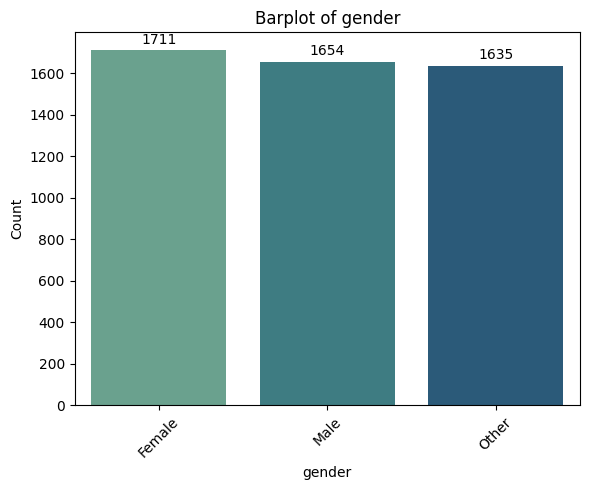

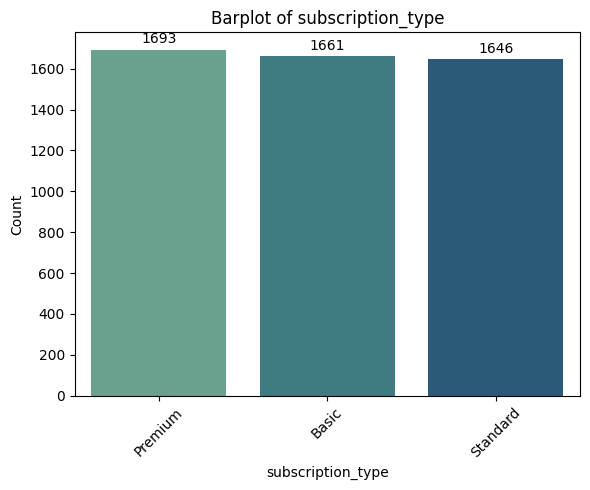

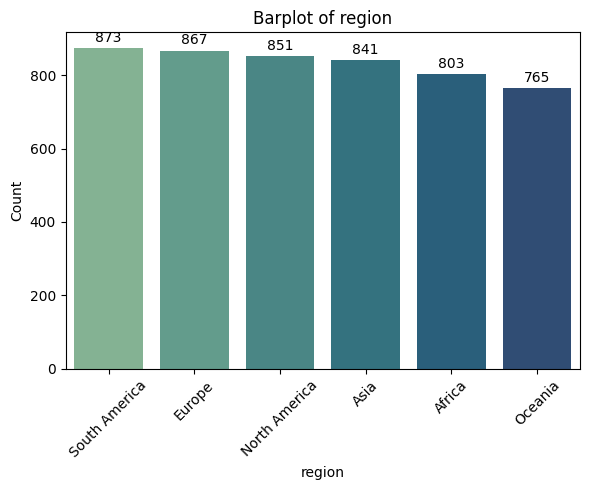

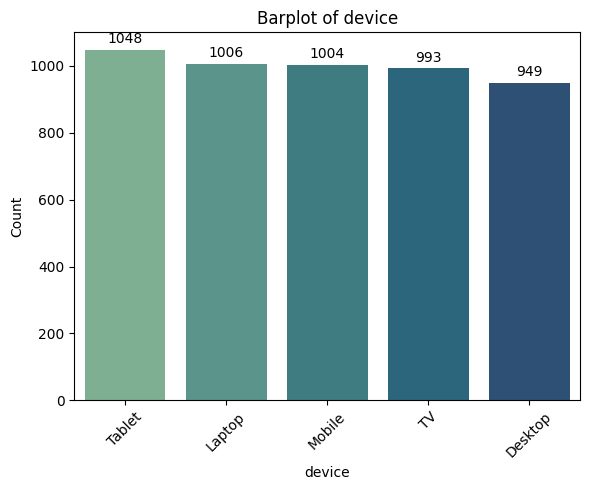

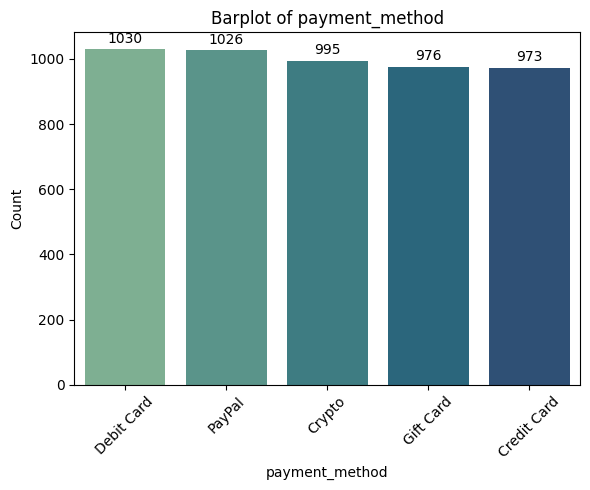

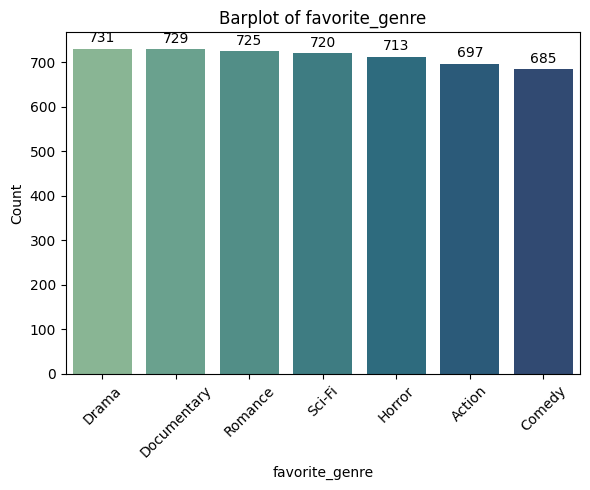

In [19]:
# create barplots for categorical features
for feature in cat_features:
    plt.figure(figsize=(6,5))
    value_counts = df[feature].value_counts()
    x = value_counts.index
    y = value_counts.values
    colors = sns.color_palette("crest", len(x))  # "husl", "Set2", or "tab10" are good options
    ax = sns.barplot(x=x, y=y, palette=colors)

    # Add annotations on top of each bar
    for i, value in enumerate(y):
        ax.text(i, value + max(y)*0.01, str(value), ha='center', va='bottom', fontsize=10)
    plt.title(f'Barplot of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Categorical univariate insights:

*  Features are fairly uniform, with most categories being equally represented (generally speaking)

### Histograms for numerical features

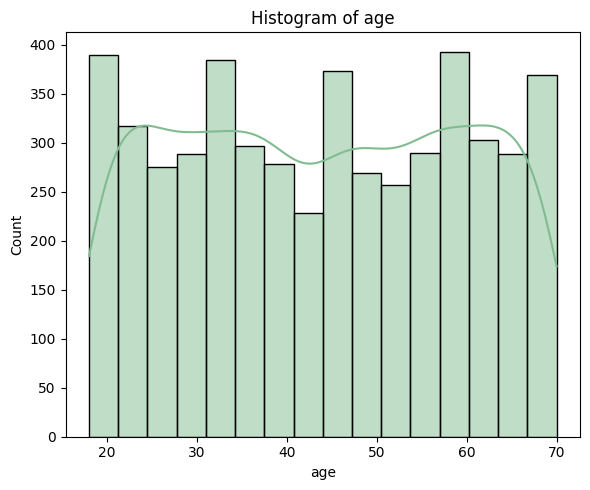

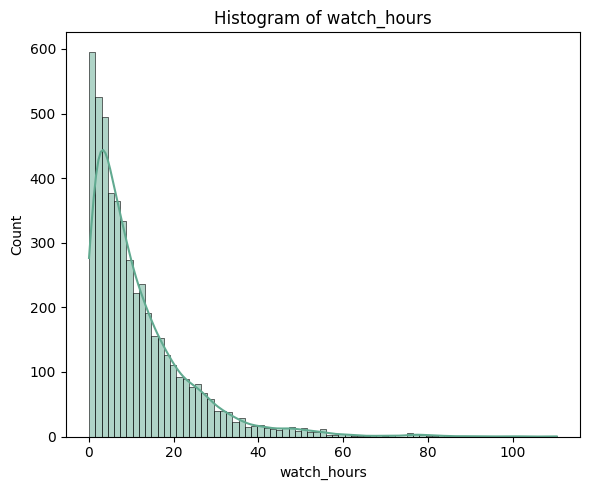

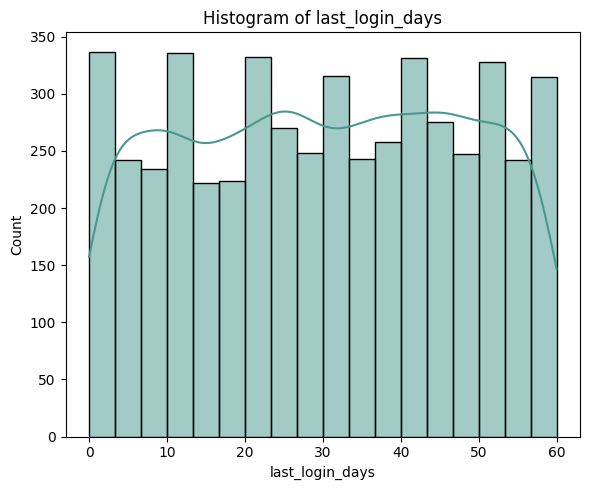

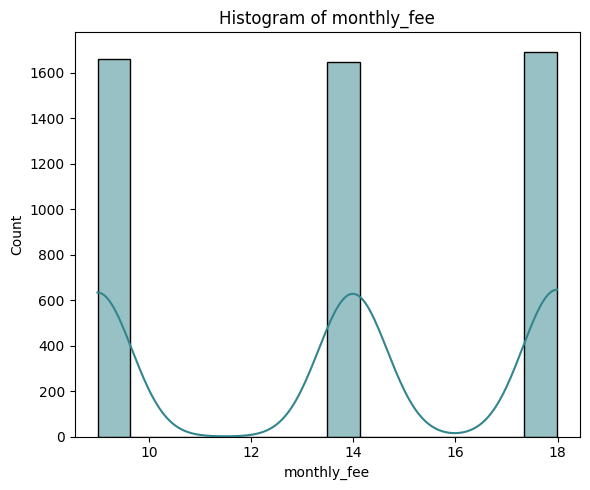

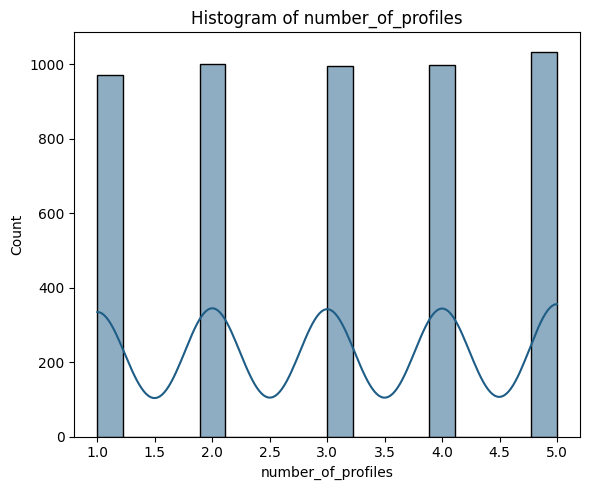

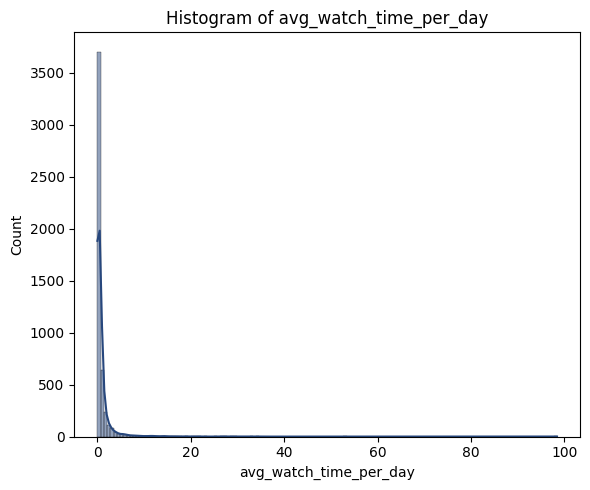

In [20]:
# create histograms for numerical features
colors = sns.color_palette("crest", len(num_features))

for i, feature in enumerate(num_features):
    if feature != 'churned':
        plt.figure(figsize=(6,5))
        sns.histplot(df[feature], kde=True, color=colors[i])
        plt.title(f'Histogram of {feature}')
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

Numerical univariate insights:

*  Most numerical features are also uniformly distributed/ multi-modal sharing stable counts across the feature
*  However, watch_hours and avg_watch_time_per_day are right skewed, as previously stated.
*  last_login_days would benefit from binning

  # Bivariate Analysis

  
  1.   Categorical vs Target: Heatmap of crosstabs
  2.   Numerical vs Target: Boxplots/Violinplots or Swarm plots
  3.   Numeric vs Numeric: Hexbin plots for engagement features
  4.   Behavioral relationships with Target: binned churn-rate curves
  5.   Effect size: mean diffs/ SMD (standardized mean diffs) 

### Categorical features:
When looking at the categorical features vs the target ("churned"), we can see:
- Women tend to churn more, with those listed as "other" churning the least.
- Customers with the basic subscription churned the most, while those with the premium subscription churned the least.
- The regions that churned the most were Europe and South America, while Africa and North America churned the least.
- Customers using laptops and mobile devices churned the most, while those using desktops and TVs churned the least.
- Customers who paid with crypto and gift cards churned the most, while those paying with credit and debit cards churned the least.
- The most popular genres for customers who churned in action, drama and horror; the most popular generes for non-churned customers are sci-fi, romance and comedy.

### Heatmaps for categorical features by target

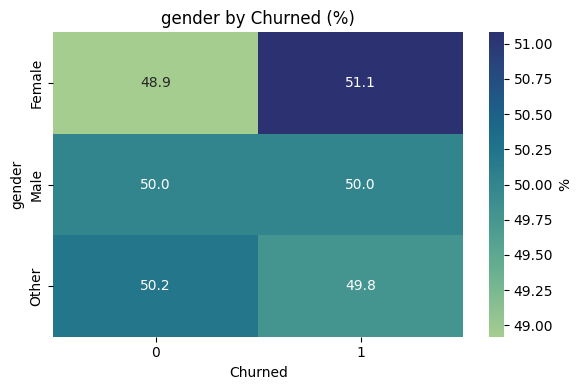

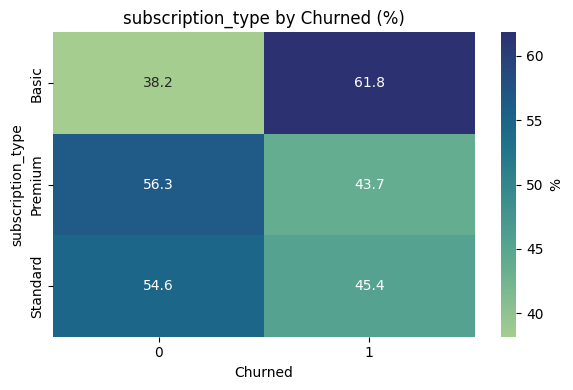

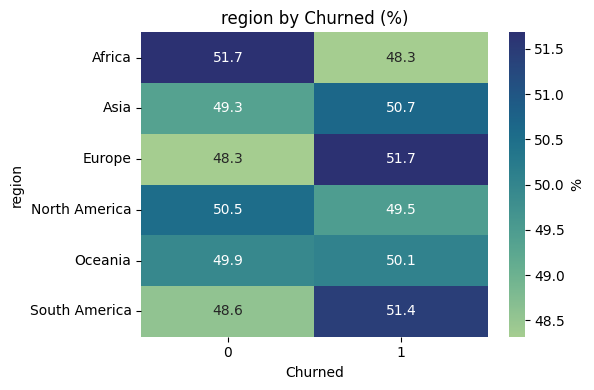

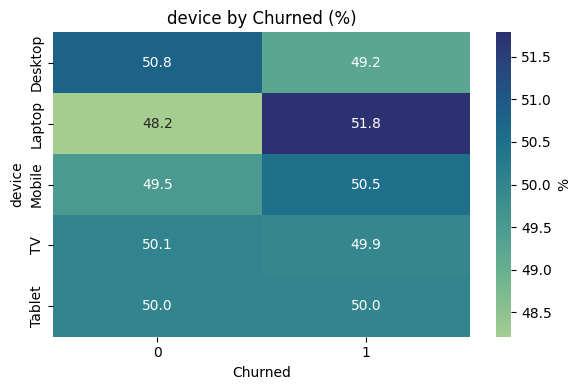

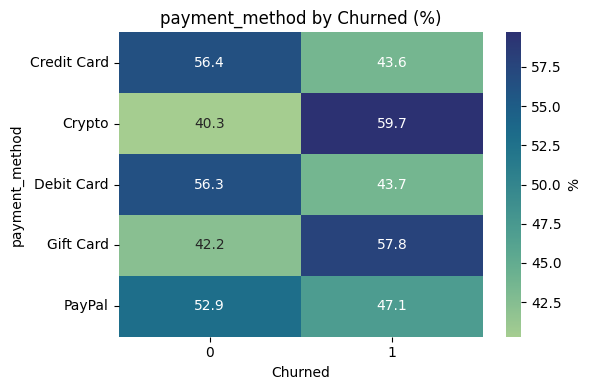

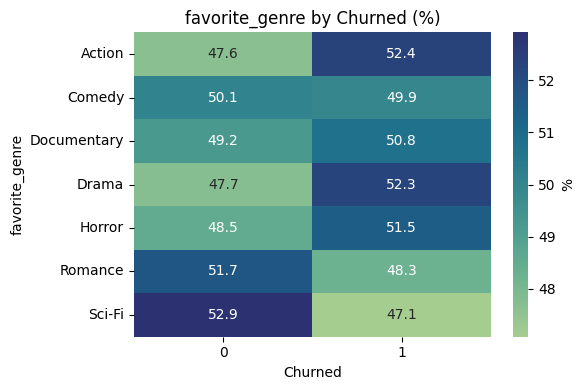

In [21]:
# create heatmaps
for feature in cat_features:
    ct = pd.crosstab(df[feature], df['churned'], normalize='index') * 100  
    plt.figure(figsize=(6,4))
    sns.heatmap(ct, annot=True, fmt=".1f", cmap="crest", cbar_kws={'label': '%'}) 
    plt.title(f'{feature} by Churned (%)')
    plt.ylabel(feature)
    plt.xlabel("Churned")
    plt.tight_layout()
    plt.show()

Categorical Distribution insights:

*  Most of the categorical features are not highly seperable by type
*  subscription_type (particularly the 'basic' subscription) show the biggest distribution difference when compared to the target
*  payment_method (particularly the 'cypto' and 'gift card' methods) show the second biggest difference when compared to the mean
*  subscription_type and payment_method appear meaningful to churn prediction

### Violin plots for numerical features by target

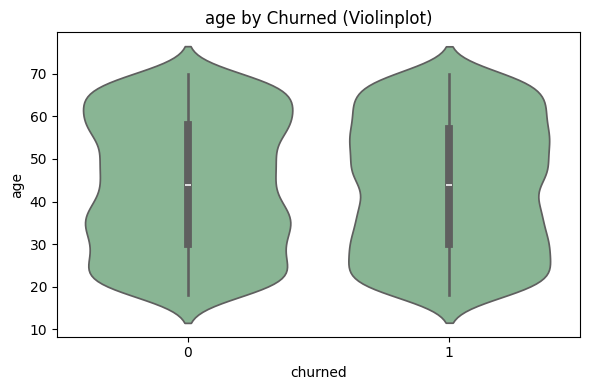

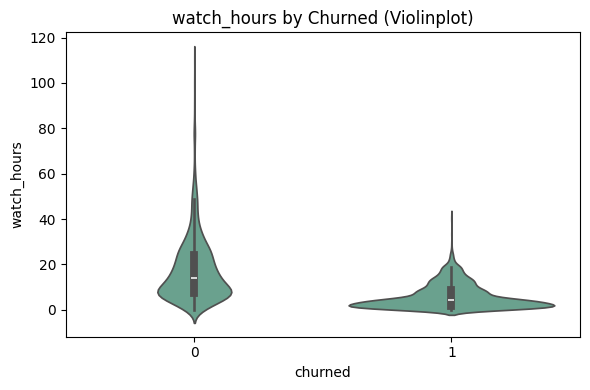

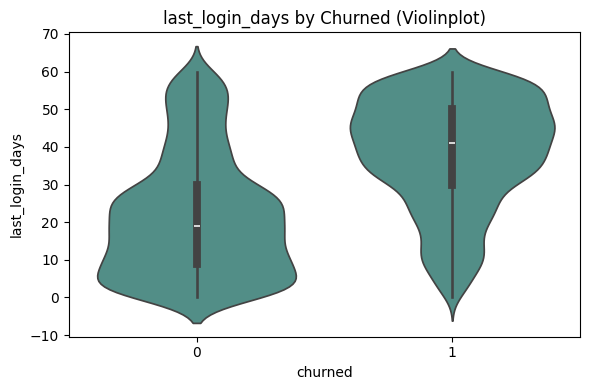

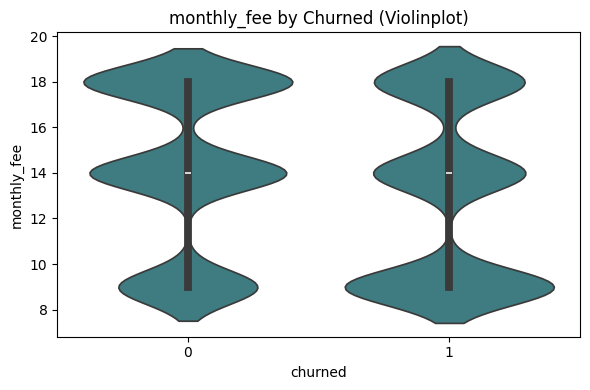

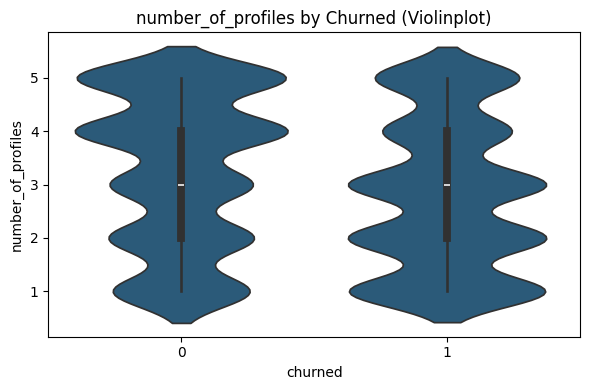

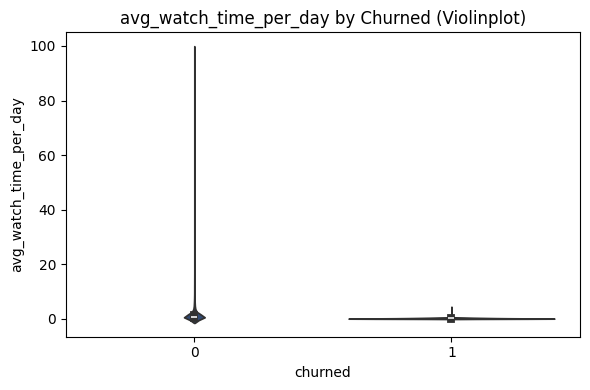

In [22]:
# create violinplots for the numerical features
colors = sns.color_palette("crest", len(num_features))

for feature in num_features:
    if feature != 'churned':
        plt.figure(figsize=(6,4))
        sns.violinplot(data=df, x='churned', y=feature, color=colors[num_features.index(feature) % len(colors)])
        plt.title(f'{feature} by Churned (Violinplot)')
        plt.tight_layout()
        plt.show()

Numeric Distribution insights:

*  Most numeric features are seperable by type, though a few stand out
*  last_login_days show the biggest distribution difference when compared by the target
*  watch_hours and avg_watch_time_per_day also so significant difference when compared by the target
*  age shows very little difference when compared by the target
*  Most features (with the exception of age) appear meaningful to churn prediction


### Hexbin plots for numerical engagement features

In [23]:
# create hexbin pairs for engagement features
hexbin_pairs = [
    ("watch_hours", "avg_watch_time_per_day"),
    ("watch_hours", "last_login_days"),
    ("watch_hours","monthly_fee"),
]

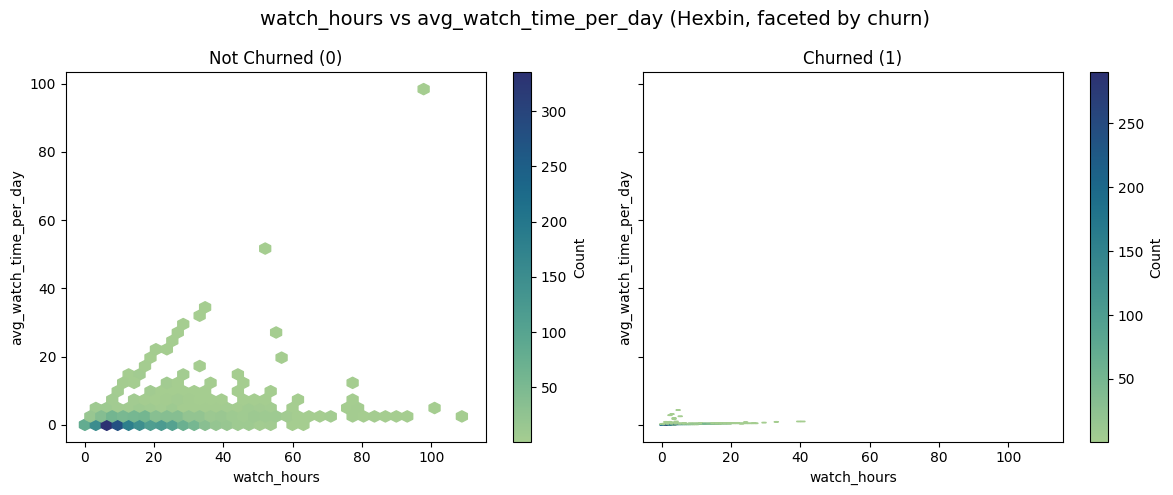

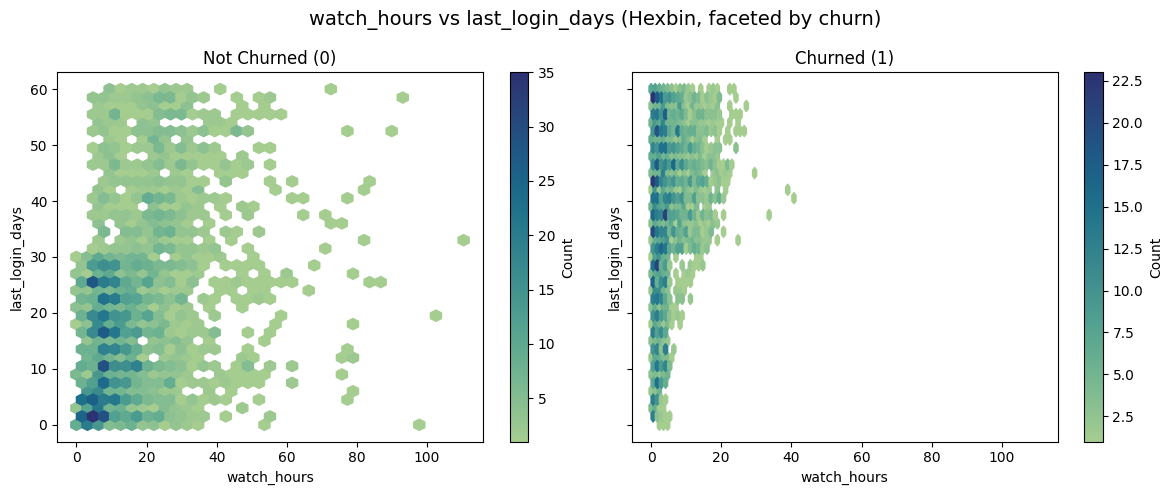

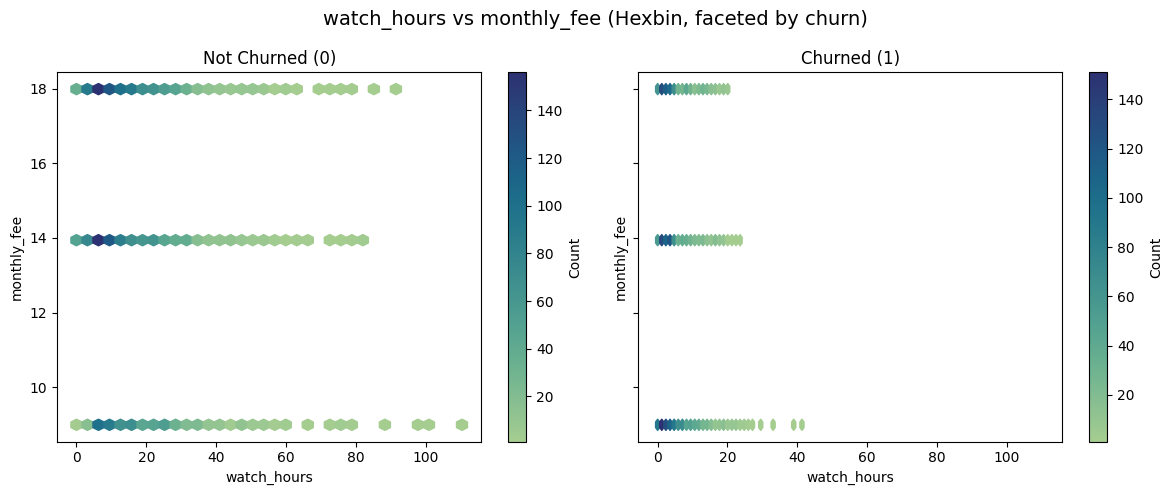

In [24]:
# create hexbin plots
cmap = sns.color_palette("crest", as_cmap=True)

for x, y in hexbin_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    for ax, churn_val, title in zip(axes,[0, 1],["Not Churned (0)", "Churned (1)"]):
        sub = df[df["churned"] == churn_val]
        hb = ax.hexbin(sub[x],sub[y], gridsize=35, mincnt=1, cmap=cmap)
        ax.set_title(title)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label("Count")

    fig.suptitle(f"{x} vs {y} (Hexbin, faceted by churn)", fontsize=14)
    plt.tight_layout()
    plt.show()

Engagement insights:

*  Engagement metrics seems to show significant distribution differences, when compared by target (as one may expect).
*  watch_hours appears to be a primary seperator, distinguishing between less recent non-churners and churners
*  monthly_fee isn't highly seperable alone, as was observed previously

### Churn rate for numerical features

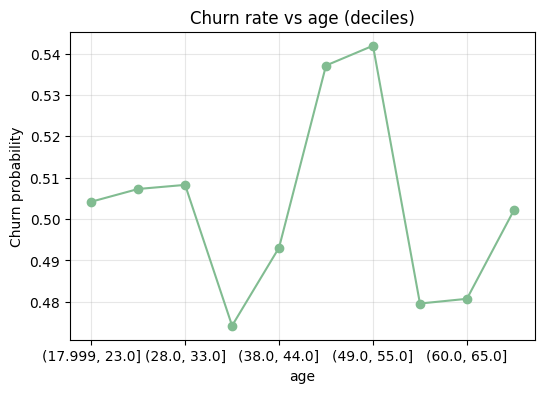

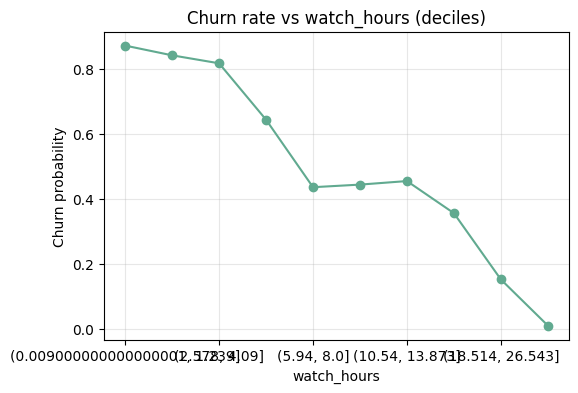

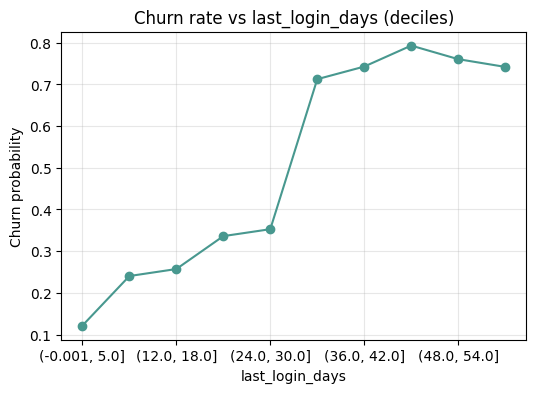

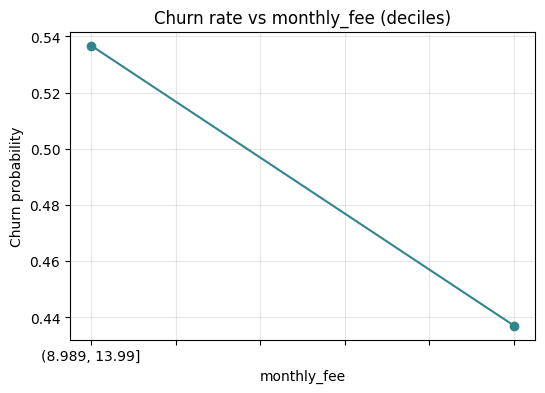

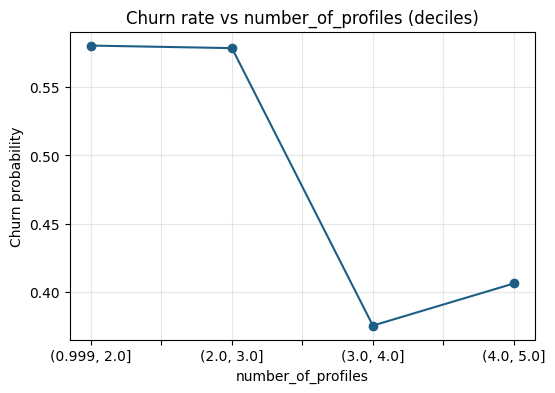

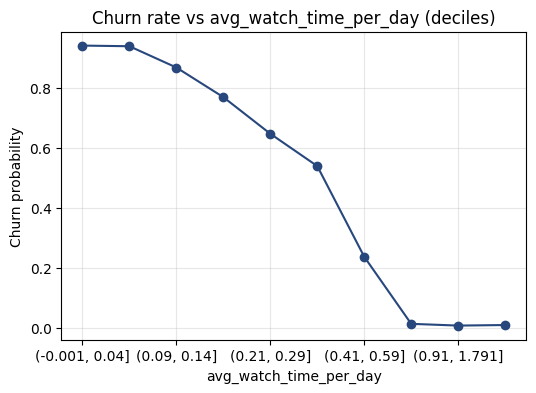

In [25]:
# create line plots/churn-rate curves for numerical features
colors = sns.color_palette("crest", len(num_features))

for col in num_features:
    if col != 'churned':
        bins = pd.qcut(df[col], q=10, duplicates="drop")
        churn_rate = df.groupby(bins)["churned"].mean()
        churn_rate.plot(marker="o", figsize=(6,4), color=colors[num_features.index(col) % len(colors)])
        plt.title(f"Churn rate vs {col} (deciles)")
        plt.ylabel("Churn probability")
        plt.xlabel(col)
        plt.grid(alpha=0.3)
        plt.show()

Churn Rate insights:
*  Clear relationships with target: watch_hours, last_login_days, avg_watch_time_per_day
*  Less clear relationships with target: number_of_profiles, monthly_fee
*  No clear relationship with target: age

### Mean Differnce for numerical features (effect size)

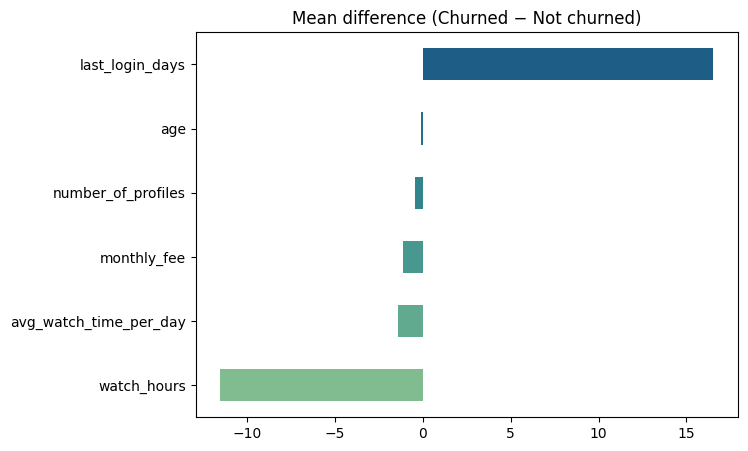

In [26]:
# mean difference plots for numerical features
diffs = {}
colors = sns.color_palette("crest", len(num_features))

for col in num_features:
    if col != 'churned':
        mean_0 = df.loc[df.churned == 0, col].mean()
        mean_1 = df.loc[df.churned == 1, col].mean()
        diffs[col] = mean_1 - mean_0

pd.Series(diffs).sort_values().plot(kind="barh", figsize=(7,5), color=colors, legend=False)
plt.title("Mean difference (Churned − Not churned)")
plt.show()

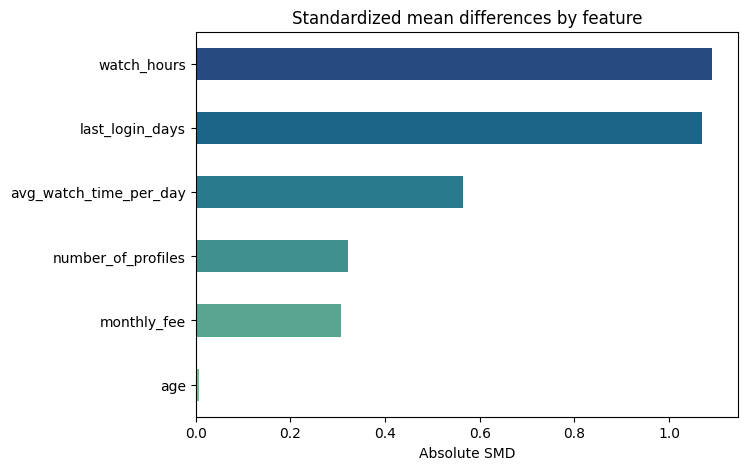

In [27]:
# standardized mean difference plots for numerical features
smd = {}

for col in num_features:
    if col != "churned":
        g0 = df.loc[df.churned == 0, col]
        g1 = df.loc[df.churned == 1, col]

        m0, m1 = g0.mean(), g1.mean()
        v0, v1 = g0.var(), g1.var()

        pooled_sd = np.sqrt((v0 + v1) / 2)
        smd[col] = (m1 - m0) / pooled_sd if pooled_sd > 0 else 0

pd.Series(smd).abs().sort_values().plot(kind="barh", figsize=(7,5), color=sns.color_palette("crest", len(smd)), legend=False)
plt.title("Standardized mean differences by feature")
plt.xlabel("Absolute SMD")
plt.show()

Standardized Mean Difference insights (|SMD| ~ 0.2 small, 0.5 medium, 0.8 large):

*  watch_hours and last_login_days reflect the largest mean difference between churners and non-churners
*  avg_watch_time_per_day shows a significant mean difference, whereas number_of_profiles and monthly_fee reflect smaller differences
*  age reflects no meaningful difference

### Correlation analysis:

In [28]:
# review data 
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


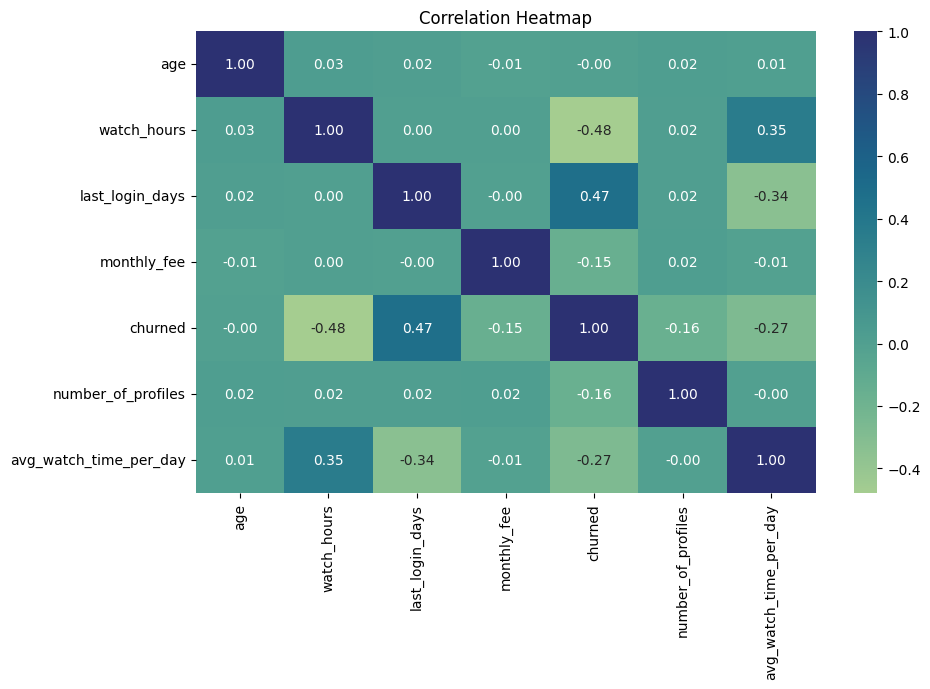

In [29]:
# create correlation heatmap
df_corr = df.copy()
corr = df_corr.corr(numeric_only=True)


plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='crest', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Correlation analysis insights:

*  Most of the numeric features are at least somewhat correlated with the target
*  watch_hours (inverse correlation) and last_login_days (positive correlation) have the strongest correlations
*  avg_watch_time_per_day, number_of_profiles, and monthly fee reflect weaker relationships with the target
*  age appears to have no relationship with the target

### Exploratory Data Analysis Summary

Several consistent patterns emerged across the exploratory analysis:

- **User engagement is the strongest signal of churn.** Metrics such as total watch hours, average watch time per day, and days since last login show clear separation between churned and retained users.
- **Engagement features are highly right-skewed**, which motivated log transformations considerations rather than aggressive outlier removal. Extreme values appear to represent legitimate high-usage behavior rather than data errors.
- **Categorical features show meaningful churn concentration**, particularly across payment method, subscription tier, and recency-of-login bins, suggesting structural or behavioral differences across user groups.
- **Price-related features matter, but primarily in combination with engagement.** Higher monthly fees alone do not imply churn, but high cost paired with low engagement corresponds to elevated churn risk.
- Overall, churn appears to be driven less by demographics and more by **behavioral disengagement**, which aligns with real-world subscription dynamics.

# Experimental Design:

A three-way split was made on the data, resulting in distinct training, validation, and test sets. Feature selection was evaluated using both statistical tests (chi-square for categorical features and ANOVA for numerical features) and cross-validated model performance, rather than relying on a single heuristic.

This allowed comparison between:

*  categorical chi2 selected features only
*  numerical f test selected features only
*  combined chi2 and f test feature sets
*  complete feature set (no subset or exclusion)

The combined chi2 and f test feature set ultimately performed best, supporting the intuition that churn is driven by both behavioral and account-level factors.

Note: **All transformations are fit on training folds only via pipelines to avoid leakage.**

In addition to experimental feature selection, experimental model selection was also employed to select a model for this binary classification task. Models that were explored include:

*  Logistic Regression
*  Support Vector Machine
*  Random Forest
*  Gradient Boosting
*  AdaBoost
*  Neural Network

Though tree-based models work very well for binary classification (and many other types of tasks), simpler models were the starting point to gauge complexity of the task. A simple MLP was also included for good measure.

### Train/validation/test split:

*  Train (~80%): model fitting + CV

*  Val (~10%): selection + tuning verification

*  Test (10%): one-time evaluation 

In [30]:
# first split: train+val vs test
X = df.drop(columns=["churned"])
y = df["churned"].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.11, stratify=y_temp, random_state=42)
# 0.11 * 0.9 = 0.1, 
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (4005, 12)
Shape of X_val: (495, 12)
Shape of X_test: (500, 12)


### Feature Preprocessing:

Based on previous analysis, several transformations are needed , including:
*  Log transformation to address skewness and heavy tails: watch_hours and avg_watch_time_per_day
*  Discretization/binning to help with interpretability and bound ranges of activity: last_login_days
*  Ordinal encoding for ordinal feature (numeric conversion): subscription_type 
*  OHE for categorical features (numeric conversion): gender, region, device, payment_method, favorite_genre, last_login_days(bin)
*  Scaling of numerical features for linear models: age, monthly_fee, number_of_profiles, watch_hours(log) , avg_watch_time_per_day(log)

Order features for preprocessing.

In [31]:
# numerical features
raw_num = ["age", "monthly_fee", "number_of_profiles"]
log_num = ["watch_hours", "avg_watch_time_per_day"]
bin_num = ["last_login_days"]

# nominal categorical features
nom_cat = ["gender", "region", "device", "payment_method", "favorite_genre"]

# ordinal categorical feature
sub_order = ['Basic', 'Standard', 'Premium']

In [32]:
# create log1p transformation function for pipeline
def log1p_df(X):
    X = pd.DataFrame(X).copy()
    return np.log1p(X)

In [33]:
# create binning transformation function for pipeline
bins = [-1, 1, 7, 14, 30, 60]
labels = ["0-1", "2-7", "8-14", "15-30", "31-60"]

def bin_last_login(X):
    X = pd.DataFrame(X).copy()
    binned = pd.cut(X.iloc[:, 0], bins=bins, labels=labels)
    return pd.DataFrame({"last_login_days": binned.astype(str)})

In [34]:
# create preprocessor column transformer all features (no subsets)
preprocessor = ColumnTransformer(
    transformers=[
        ("num_raw", Pipeline([("scaler", StandardScaler())]), raw_num),
        ("num_log", Pipeline([("log", FunctionTransformer(log1p_df, feature_names_out="one-to-one")), ("scaler", StandardScaler()),]), log_num),
        ("last_login_bin", Pipeline([("bin", FunctionTransformer(bin_last_login, feature_names_out="one-to-one")), ("ohe", OneHotEncoder(handle_unknown="ignore")),]), bin_num),
        ("cat_nom", OneHotEncoder(handle_unknown="ignore"), nom_cat),
        ("sub_ord", OrdinalEncoder(categories=[sub_order]), ["subscription_type"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

### Statisical Tests for feature selection

1. Chi-squared test (chi2)
2. ANOVA test (f_classif)



Pipelines will be created for each feature set (categorical and numeric), to guage the predictive power/signal strength of each set, then the best performing set will be selected for modeling. 
*  Selected chi2 categorical features only
*  Selected f score/anova numerical features only
*  Complete feature set (no sub selection)
*  Selected chi2 and f score/anova features only

Note: As chi2 requires non-negative/features, its branches should use ohe/min-max or categoricals only

In [35]:
# create numerical preprocessor
num_preprocessor = ColumnTransformer(
    transformers=[
        ('raw_num', Pipeline([('scaler', StandardScaler())]), raw_num),
        ('log_num', Pipeline([('log_transform', FunctionTransformer(log1p_df,feature_names_out="one-to-one")),('scaler', StandardScaler())]), log_num),
    ],
    remainder='drop', verbose_feature_names_out=False
)

In [36]:
# create f pipeline
num_branch = Pipeline([
    ("num_prep", num_preprocessor),
    ("num_select", SelectKBest(score_func=f_classif, k=5)),
    ("model", LogisticRegression(max_iter=1000, random_state=5))
])

In [37]:
# use cross validation to determine the signal strength of the selected f test features
f_scores = cross_val_score(
    num_branch,  
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
)

print(f'The signal strength of just the f test selected numerical features alone: {f_scores.mean()}')
print(f'F test scores std: {f_scores.std()}')

The signal strength of just the f test selected numerical features alone: 0.9561267877850792
F test scores std: 0.006570377541011563


In [38]:
# create categorical preprocessor
cat_preprocessor = ColumnTransformer(
    transformers=[
        ("last_login_bin", Pipeline([("bin", FunctionTransformer(bin_last_login, feature_names_out="one-to-one")),("ohe", OneHotEncoder(handle_unknown="ignore")),]), bin_num),
        ("cat_nom", OneHotEncoder(handle_unknown="ignore"), nom_cat),
        ("sub_ord", OrdinalEncoder(categories=[sub_order]), ["subscription_type"]),
    ],
    remainder="drop", verbose_feature_names_out=False
)

In [39]:
# create chi2 pipeline
cat_branch = Pipeline([
    ("prep", cat_preprocessor),
    ("select", SelectKBest(score_func=chi2, k=11)),
    ("model", LogisticRegression(max_iter=2000, random_state=5)),
])

In [40]:
# use cross validation to determine the signal strength of the selected chi2 features
chi2_scores = cross_val_score(cat_branch, X_train, y_train, cv=5, scoring="roc_auc",)

print(f'The signal strength of just the chi2 selected numeric features alone: {chi2_scores.mean()}')
print(f'Chi2 scores std: {chi2_scores.std()}')

The signal strength of just the chi2 selected numeric features alone: 0.8077509133758121
Chi2 scores std: 0.010462861372546805


In [41]:
# Summary of several iterations of k for chi2 [5,8,10,12,15]

"""
# chi2 k=5
The signal strength of just the chi2 selected numeric features alone: 0.7649220045637618
Chi2 scores std: 0.010057334560451109

# chi2 k=8
The signal strength of just the chi2 selected numeric features alone: 0.805045699963839
Chi2 scores std: 0.014364777559123545

# chi2 k=10
The signal strength of just the chi2 selected numeric features alone: 0.8073980323453496
Chi2 scores std: 0.01046412001794181

# chi2 k=12
The signal strength of just the chi2 selected numeric features alone: 0.8072265795478634
Chi2 scores std: 0.011129237557905743

# chi2 k=15
The signal strength of just the chi2 selected numeric features alone: 0.8060426200481317
Chi2 scores std: 0.01171203944013404"""

'\n# chi2 k=5\nThe signal strength of just the chi2 selected numeric features alone: 0.7649220045637618\nChi2 scores std: 0.010057334560451109\n\n# chi2 k=8\nThe signal strength of just the chi2 selected numeric features alone: 0.805045699963839\nChi2 scores std: 0.014364777559123545\n\n# chi2 k=10\nThe signal strength of just the chi2 selected numeric features alone: 0.8073980323453496\nChi2 scores std: 0.01046412001794181\n\n# chi2 k=12\nThe signal strength of just the chi2 selected numeric features alone: 0.8072265795478634\nChi2 scores std: 0.011129237557905743\n\n# chi2 k=15\nThe signal strength of just the chi2 selected numeric features alone: 0.8060426200481317\nChi2 scores std: 0.01171203944013404'

In [42]:
# create chi2 and f test pipeliens containing only preprocessing and feature selection steps
chi2_branch_combined = Pipeline([
    ("prep_cat", cat_preprocessor),
    ("select_cat", SelectKBest(score_func=chi2, k=11)),
])

f_branch_combined = Pipeline([
    ("prep_num", num_preprocessor),
    ("select_num", SelectKBest(score_func=f_classif, k=5)),
])

In [43]:
# create a combined feature set using featureunion
combined_features = FeatureUnion([
    ("chi2", chi2_branch_combined),
    ("f", f_branch_combined),
])

In [44]:
# create combined pipeline
combined_pipe = Pipeline([
    ("features", combined_features),
    ("model", LogisticRegression(max_iter=1000, random_state=5))
])

In [45]:
# use cross validation to determine the signal strength of the combined feature set
combined_scores = cross_val_score(
    combined_pipe,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print(f'The signal strength of all features with (chi2 and f test) statistical selection: {combined_scores.mean()}')
print(f'Std: {combined_scores.std()}')

The signal strength of all features with (chi2 and f test) statistical selection: 0.9793483546766091
Std: 0.0026729077714603864


In [46]:
# create pipeline for complete feature set
full_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=5))
])

In [47]:
# use cross validation to determine the signal strength of all the features
full_scores = cross_val_score(
    full_pipe,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print(f'The signal strength of all features without statistical selection: {full_scores.mean()}')
print(f'Std: {full_scores.std()}')

The signal strength of all features without statistical selection: 0.978709926805242
Std: 0.0026018293485912435


### Model Selection:

*  Multiple model families were evaluated using **cross-validation** and **multiple metrics** (ROC-AUC, recall, F1, accuracy). 

*  **Recall** was emphasized during tuning to prioritize identifying at-risk customers, reflecting a retention-focused use case.

*  **AdaBoost** provided the best balance of performance and stability after hyperparameter tuning and was selected as the final model. 

*  Final evaluation was conducted on a held-out test set to avoid optimistic bias.







### Metric selection:
Model optimization prioritized **recall** as the primary objective. In a churn context, false negatives — failing to identify users who will churn — represent missed opportunities for retention interventions.

From a business perspective:
- A **false negative** (failing to identify a churned customer) results in a lost customer and unrealized lifetime value (usually more expensive).
- A **false positive** (flagging an active/engaged customer as churned) may incur a retention offer cost (wasted incentives), but does not directly result in customer loss.

While recall was optimized during model selection, additional metrics (precision, accuracy, and ROC AUC) were tracked to ensure balanced performance and avoid excessive false positives. Threshold tuning is identified as a natural next step for aligning model behavior with specific retention cost constraints.

Instantiating and evaluating base model performance

In [48]:
# models
models = {'Logistic Regression': LogisticRegression(random_state=5, max_iter=1000),
          'Support Vector Machine': SVC(random_state=5, probability=True),
          'Random Forest': RandomForestClassifier(random_state=5),
          'Gradient Boosting': GradientBoostingClassifier(random_state=5),
          'AdaBoost': AdaBoostClassifier(random_state=5,n_estimators=100),
          'Neural Network': MLPClassifier(random_state=5, max_iter=1000)}

In [49]:
# get baseline performance for each model using the combined feature set
for name, model in models.items():
    pipe = Pipeline([
        ("prep", combined_features),
        ("model", model)
    ])

    scoring = {"roc_auc":"roc_auc", "recall":"recall", "f1":"f1", "accuracy":"accuracy"}
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

    # print out the name of each model and each of its scores with its name
    print(f'{name}: roc_auc: {scores["test_roc_auc"].mean():.3f}, roc_auc std: {scores["test_roc_auc"].std():.3f}, recall: {scores["test_recall"].mean():.3f}, f1: {scores["test_f1"].mean():.3f}, accuracy: {scores["test_accuracy"].mean():.3f}\n')

Logistic Regression: roc_auc: 0.979, roc_auc std: 0.003, recall: 0.924, f1: 0.918, accuracy: 0.917

Support Vector Machine: roc_auc: 0.991, roc_auc std: 0.001, recall: 0.950, f1: 0.952, accuracy: 0.951

Random Forest: roc_auc: 0.999, roc_auc std: 0.000, recall: 0.982, f1: 0.989, accuracy: 0.989

Gradient Boosting: roc_auc: 0.999, roc_auc std: 0.001, recall: 0.984, f1: 0.987, accuracy: 0.987

AdaBoost: roc_auc: 0.999, roc_auc std: 0.001, recall: 0.990, f1: 0.989, accuracy: 0.989

Neural Network: roc_auc: 0.995, roc_auc std: 0.002, recall: 0.957, f1: 0.959, accuracy: 0.959



In [50]:
# identify the best performing model
best_model_name = 'AdaBoost'
best_model = models[best_model_name]

Perform Grid search on the best performing model

In [51]:
# recreate the pipeline used for the best performing model, then pass to gridsearch
ada_pipe = Pipeline([
    ("prep", combined_features),
    ("model", AdaBoostClassifier(random_state=5)) 
])  

In [52]:
# create params
params = {
    'model__n_estimators': [25, 50, 100, 200, 400],
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
}

# instantiate gridsearch
grid = GridSearchCV(ada_pipe, param_grid=params, cv=5, scoring="recall", n_jobs=-1, refit=True, verbose=1) 

# fit gridsearch
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=5))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__learning_rate': [0.001, 0.01, ...], 'model__n_estimators': [25, 50, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the sc

In [53]:
# get the params and recall score of the best model
best_pipe = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV recall:", grid.best_score_)

Best params: {'model__learning_rate': 0.5, 'model__n_estimators': 400}
Best CV recall: 0.9950372208436724


In [54]:
# evaluate on the validation set
y_val_pred = best_pipe.predict(X_val)
print("VALIDATION")
print(f'Classification Report: {classification_report(y_val, y_val_pred)}')

# get probabilities for roc curve
y_val_pred_proba = best_pipe.predict_proba(X_val)[:, 1] 
print("Validation ROC AUC score:", roc_auc_score(y_val, y_val_pred_proba))

VALIDATION
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       249

    accuracy                           1.00       495
   macro avg       1.00      1.00      1.00       495
weighted avg       1.00      1.00      1.00       495

Validation ROC AUC score: 1.0


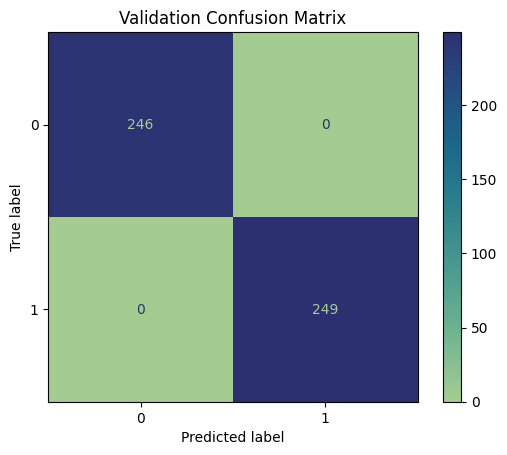

In [55]:
# create validation confusion matrix
v_cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=v_cm, display_labels=best_pipe.classes_)
disp.plot(cmap='crest')
plt.title('Validation Confusion Matrix')
plt.show()

In [56]:
# get train predictions so they can be compared to validation to check for overfitting
y_train_pred = best_pipe.predict(X_train)
y_train_proba = best_pipe.predict_proba(X_train)[:, 1]

print("TRAIN")
print(classification_report(y_train, y_train_pred))
print("Train ROC AUC:", roc_auc_score(y_train, y_train_proba))

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1990
           1       1.00      1.00      1.00      2015

    accuracy                           1.00      4005
   macro avg       1.00      1.00      1.00      4005
weighted avg       1.00      1.00      1.00      4005

Train ROC AUC: 0.999972318166515


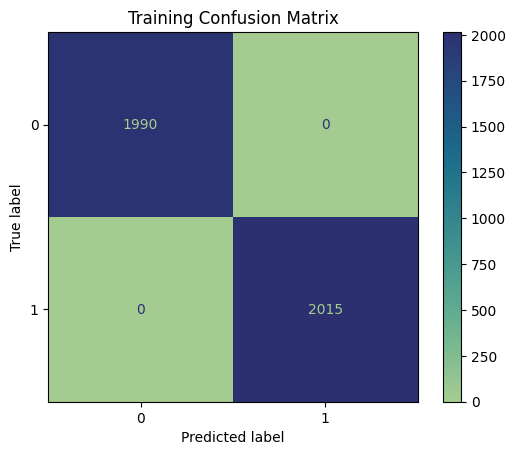

In [57]:
# create training confusion matrix
train_cm = confusion_matrix(y_train, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=best_pipe.classes_)
disp.plot(cmap='crest')
plt.title('Training Confusion Matrix')
plt.show()

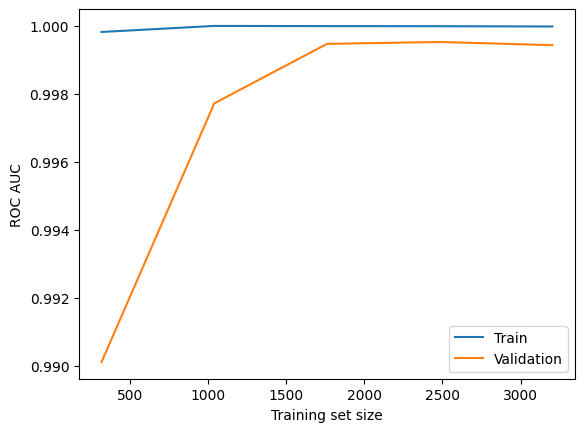

In [58]:
# plot the learning curves to verify model isn't overfitting
train_sizes, train_scores, val_scores = learning_curve(estimator=best_pipe, X=X_train, y=y_train, cv=5, scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.xlabel("Training set size")
plt.ylabel("ROC AUC")
plt.legend()
plt.show()

### Final training


In [59]:
# retrain on train+val, evaluate on test set
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

final_model = best_pipe  # has best params for adaboost
final_model.fit(X_trainval, y_trainval)

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("TEST Recall:", test_recall)
print("TEST Precision:", test_precision)
print("TEST Accuracy:", test_accuracy)
print("TEST ROC AUC:", test_roc_auc)

TEST Recall: 0.9960159362549801
TEST Precision: 0.9920634920634921
TEST Accuracy: 0.994
TEST ROC AUC: 0.999327989247828


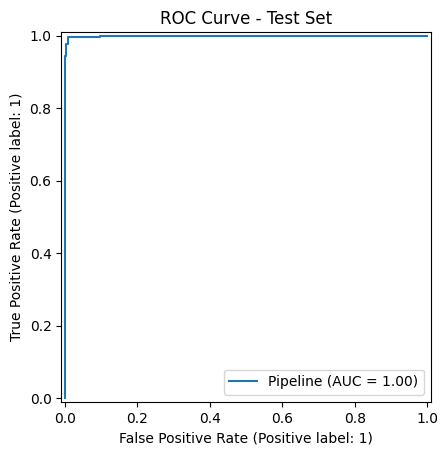

In [60]:
# display roc curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.title('ROC Curve - Test Set')
plt.show()

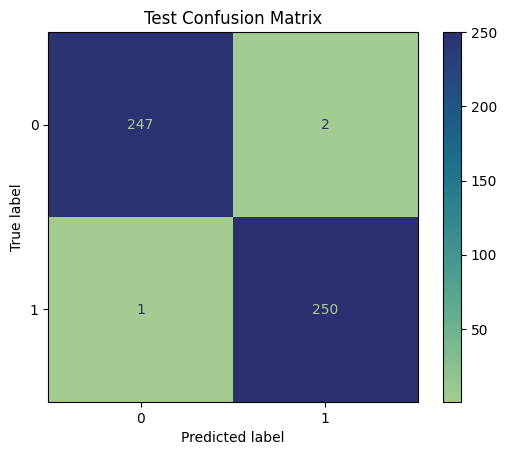

In [61]:
# create test confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=best_pipe.classes_)
disp.plot(cmap='crest')
plt.title('Test Confusion Matrix')
plt.show()

Note: While model-based feature importance reflects how the AdaBoost classifier internally weighted features, permutation importance provides a model-agnostic validation by measuring performance degradation when features are disrupted, so both will be used.

In [62]:
# get feature names and feature importance
feature_names = final_model.named_steps['prep'].get_feature_names_out()
importances = final_model.named_steps['model'].feature_importances_
print(len(feature_names), len(importances))

16 16


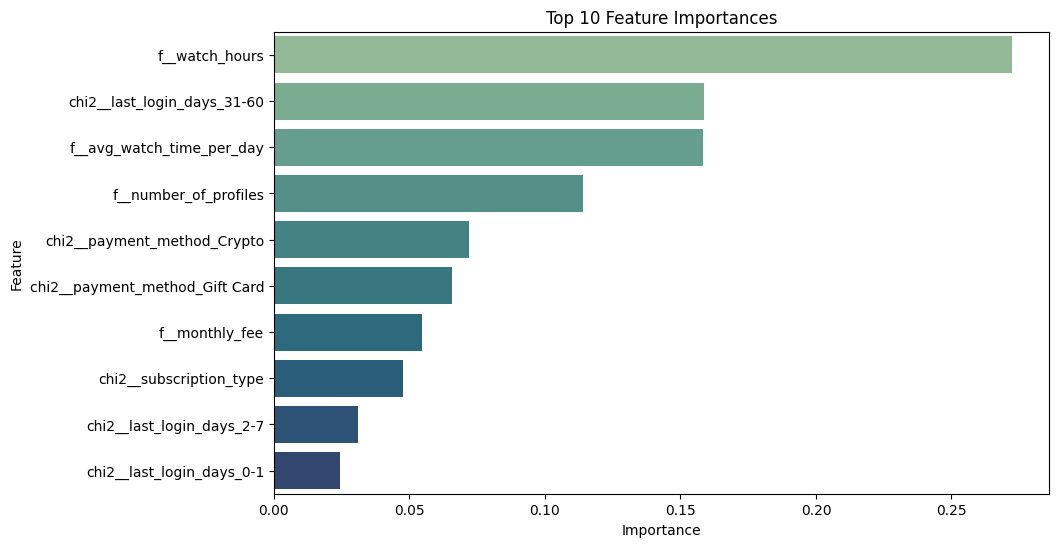

In [63]:
# visualize feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='crest')
plt.title('Top 10 Feature Importances')
plt.show()

Feature importance (model-based) insights:

* Model-based feature importance aligns closely with trends observed during exploratory data analysis, indicating that the AdaBoost model learned meaningful and intuitive relationships in the data.
* Engagement-related features — including watch_hours, avg_watch_time_per_day, and login recency — dominate the model’s internal weighting, reinforcing disengagement as the primary driver of churn.
* Account and billing characteristics, including payment method and subscription tier, contribute additional explanatory power, suggesting churn risk is shaped by both usage behavior and subscription context.


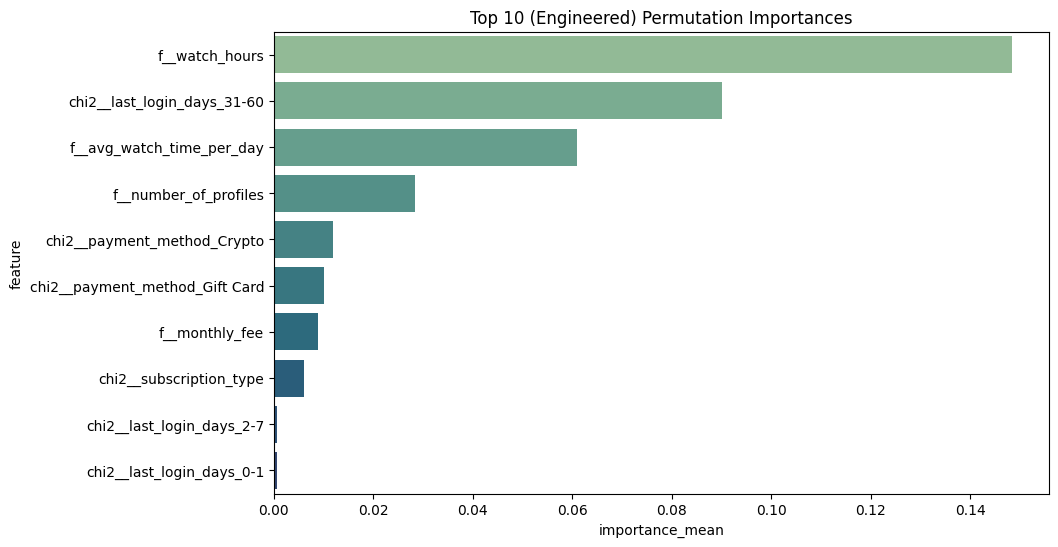

In [64]:
# Compute permutation importance for engineered features
prep = final_model.named_steps["prep"]   
model = final_model.named_steps["model"] 
X_test_eng = prep.transform(X_test)

try:
    X_test_eng_dense = X_test_eng.toarray()
except AttributeError:
    X_test_eng_dense = X_test_eng

result = permutation_importance(model, X_test_eng_dense, y_test, n_repeats=5, random_state=5, n_jobs=-1, scoring="roc_auc") 
pi = pd.DataFrame({"feature": feature_names,"importance_mean": result.importances_mean,"importance_std": result.importances_std}).sort_values("importance_mean", ascending=False)

#display(pi.head(20))
plt.figure(figsize=(10,6))
sns.barplot(data=pi.head(10), x='importance_mean', y='feature', palette='crest')
plt.title('Top 10 (Engineered) Permutation Importances')
plt.show()


Permutation importance (engineered features) insights:

* Permutation importance validates the model-based importance rankings by directly measuring performance degradation when individual engineered features are disrupted.
* Log-transformed engagement metrics and binned recency indicators — particularly longer inactivity windows (>30 days) — result in the largest drops in predictive performance, confirming their central role in churn prediction.
* Additional features related to account structure and billing context (number_of_profiles, monthly_fee, specific payment methods) contribute incremental signal, refining churn risk beyond engagement alone.

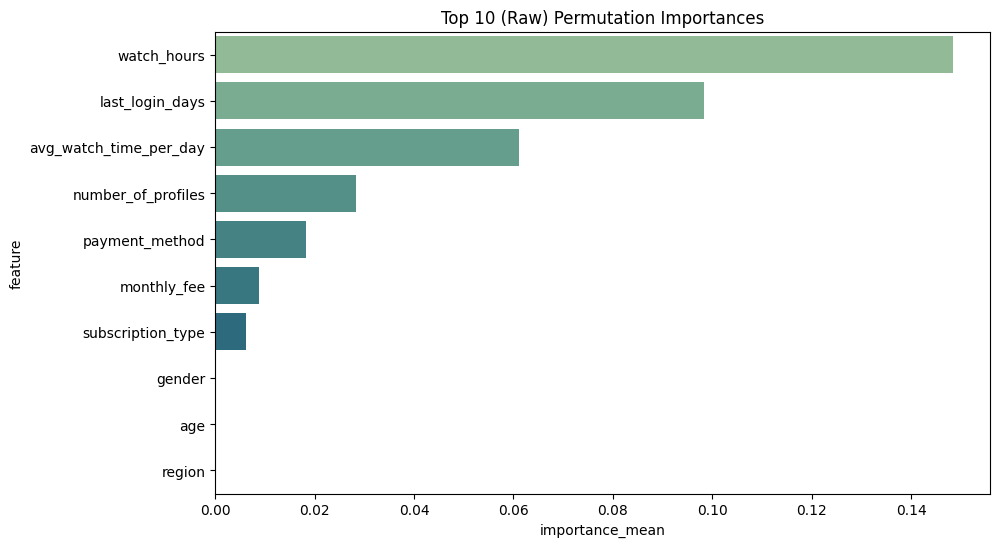

In [65]:
# Compute permutation importance for engineered features
result_raw = permutation_importance(final_model, X_test, y_test, n_repeats=5, random_state=5, n_jobs=-1, scoring="roc_auc")
pi_raw = pd.DataFrame({"feature": X_test.columns, "importance_mean": result_raw.importances_mean, "importance_std": result_raw.importances_std}).sort_values("importance_mean", ascending=False)

#display(pi_raw.head(20))
plt.figure(figsize=(10,6))
sns.barplot(data=pi_raw.head(10), x='importance_mean', y='feature', palette='crest')
plt.title('Top 10 (Raw) Permutation Importances')
plt.show()

Permutation importance (raw features):

* Raw-feature permutation importance shows that a small set of intuitive behavioral variables explains the majority of the model’s predictive power.
* Overall usage intensity (watch_hours), recency of activity (last_login_days), and average engagement levels drive the strongest performance declines when permuted, highlighting their robustness as churn indicators.
* In contrast, demographic variables such as age, gender, and region exhibit minimal impact on model performance, suggesting churn behavior in this dataset is driven primarily by user engagement patterns rather than demographic characteristics.

### Model Performance Insights:


The final model achieves very strong performance on the held-out test set, including near-perfect ROC AUC and high recall and precision.

Several factors likely contribute to this result:
- The dataset exhibits **strong behavioral separability**, particularly in engagement features that closely precede churn events.
- Churn appears to be directly linked to recent disengagement patterns (e.g., low watch time and long inactivity), which are well-captured by the feature set.
- All preprocessing and feature selection steps were confined to training data via pipelines, reducing the risk of leakage.

While the performance is unusually high, the results are consistent with the structure of the data and were validated using a strict train/validation/test split. Additionally, plotting the learning curve of the model, as well as calculating the permuation importance, confirmed a lack of overfitting or data leakage.

Importance insights:

*  Taken together, the engineered and raw permutation importances, strongly reinforcing the EDA findings, suggest that the model’s strong performance is driven by a small number of highly interpretable behavioral features, rather than leakage or reliance on obscure proxy variables.


## Error Analysis:


In [66]:
# get complete list of post-processed features
ct = final_model.named_steps['prep']           
feature_names = ct.get_feature_names_out()
print(feature_names)

['chi2__last_login_days_0-1' 'chi2__last_login_days_15-30'
 'chi2__last_login_days_2-7' 'chi2__last_login_days_31-60'
 'chi2__last_login_days_8-14' 'chi2__payment_method_Credit Card'
 'chi2__payment_method_Crypto' 'chi2__payment_method_Debit Card'
 'chi2__payment_method_Gift Card' 'chi2__payment_method_PayPal'
 'chi2__subscription_type' 'f__age' 'f__monthly_fee'
 'f__number_of_profiles' 'f__watch_hours' 'f__avg_watch_time_per_day']


In [67]:
# transform data and ensure its a 2d array
X_test_transformed = ct.transform(X_test)

if sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

Xt = np.asarray(X_test_transformed)

print("Xt shape:", Xt.shape)
print("num feature names:", len(feature_names))

Xt shape: (500, 16)
num feature names: 16


In [68]:
# create the transformed dataframe
X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=feature_names,   
    index=X_test.index
)

In [69]:
# build analysis dataframe
error_df = X_test_transformed.copy()
error_df["y_true"] = y_test
error_df["y_pred"] = y_test_pred
error_df["y_proba"] = y_test_proba

In [70]:
# label the errors
error_df["error_type"] = np.where(
    (error_df.y_true == 1) & (error_df.y_pred == 0), "False Negative",
    np.where(
        (error_df.y_true == 0) & (error_df.y_pred == 1), "False Positive",
        "Correct"
    )
)

error_df.head()

,chi2__last_login_days_0-1,chi2__last_login_days_15-30,chi2__last_login_days_2-7,chi2__last_login_days_31-60,chi2__last_login_days_8-14,chi2__payment_method_Credit Card,chi2__payment_method_Crypto,chi2__payment_method_Debit Card,chi2__payment_method_Gift Card,chi2__payment_method_PayPal,chi2__subscription_type,f__age,f__monthly_fee,f__number_of_profiles,f__watch_hours,f__avg_watch_time_per_day,y_true,y_pred,y_proba,error_type
4704,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.826672,0.085319,1.399035,1.143657,0.051102,0,0,0.301449,Correct
496,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.656848,-1.270381,-1.423813,-0.284827,-0.575039,1,1,0.681981,Correct
3742,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.826672,-1.270381,-0.718101,-0.849097,-0.758009,1,1,0.770845,Correct
3283,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,-1.407180,1.169879,-0.718101,0.848875,1.185780,0,0,0.267120,Correct
4718,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.375166,0.085319,0.693323,-0.309946,-0.472748,0,0,0.372792,Correct


In [71]:
# count the errors
errors_only = error_df[error_df["error_type"] != "Correct"]
errors_only["error_type"].value_counts()

error_type
False Positive    2
False Negative    1
Name: count, dtype: int64

In [72]:
# original numerical features
raw_num_cols = ["age", "monthly_fee", "number_of_profiles", "watch_hours", "avg_watch_time_per_day", "last_login_days"]

# log transform watch hours and avg watch time per day
X_test_raw = X_test.copy()
X_test_raw["log_watch_hours"] = np.log1p(X_test_raw["watch_hours"])
X_test_raw["log_avg_watch_time_per_day"] = np.log1p(X_test_raw["avg_watch_time_per_day"])

# add original features to error df
errors_only_raw = errors_only.join(X_test_raw)

In [73]:
# compare the distros for errors and correct predictions
num_cols = ["age", "log_watch_hours", "log_avg_watch_time_per_day", "monthly_fee", "number_of_profiles", "last_login_days"]
errors_only_raw.groupby("error_type")[num_cols].mean()

,age,log_watch_hours,log_avg_watch_time_per_day,monthly_fee,number_of_profiles,last_login_days
error_type,,,,,,
False Negative,26.0,1.729884,0.457425,13.99,1.0,7.0
False Positive,42.5,0.310960,0.130874,15.99,2.0,1.5


In [74]:
# seperate categorical features and add them to df
cat_cols =  ["gender", "region", "device", "payment_method", "favorite_genre", "subscription_type",]
errors_only_cat = errors_only.join(X_test[cat_cols])

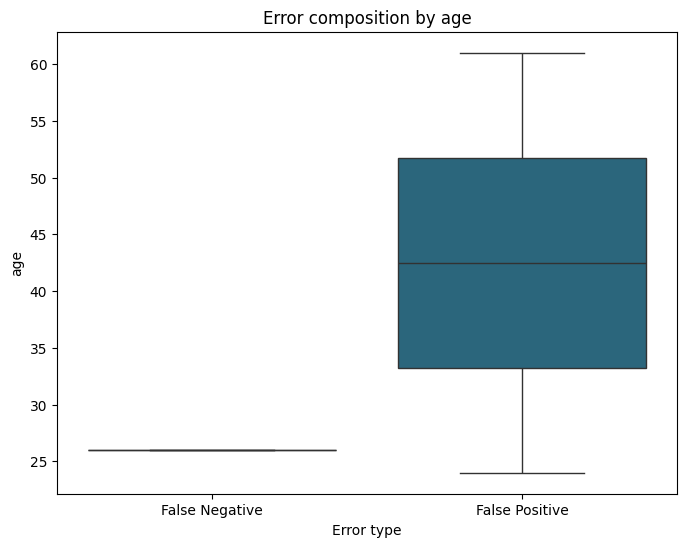

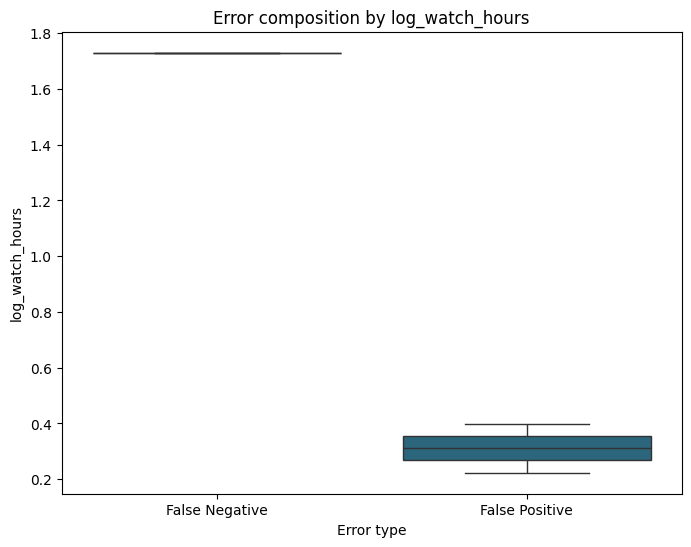

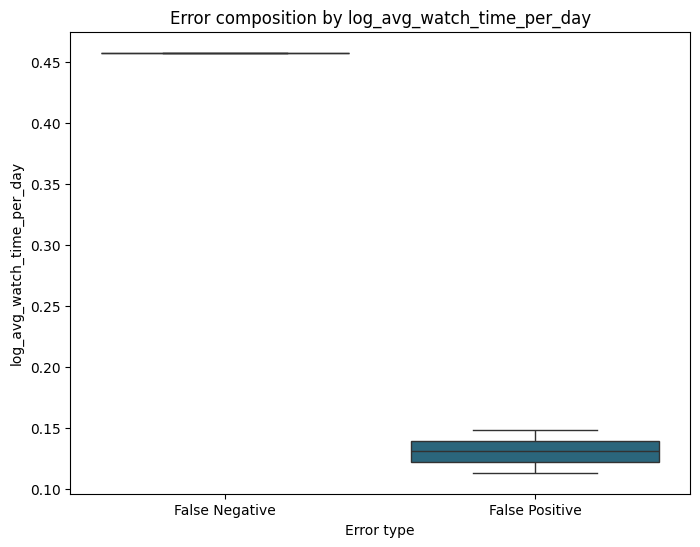

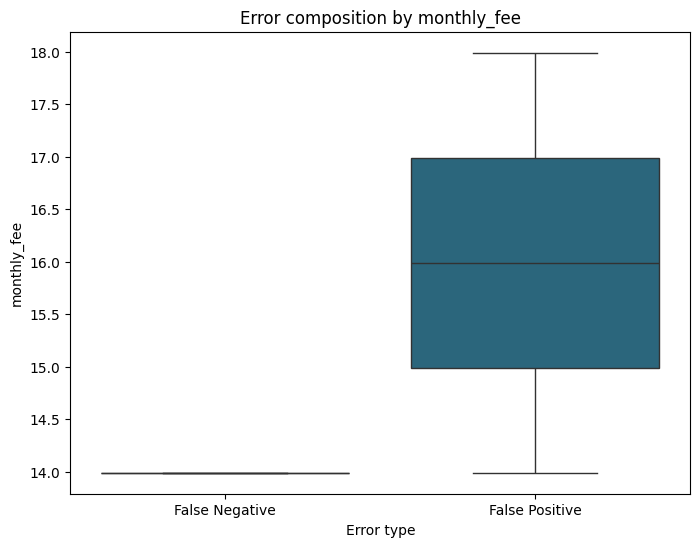

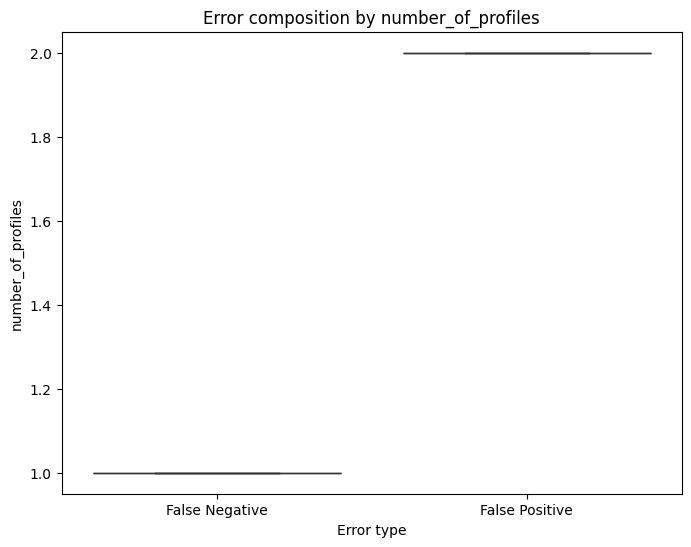

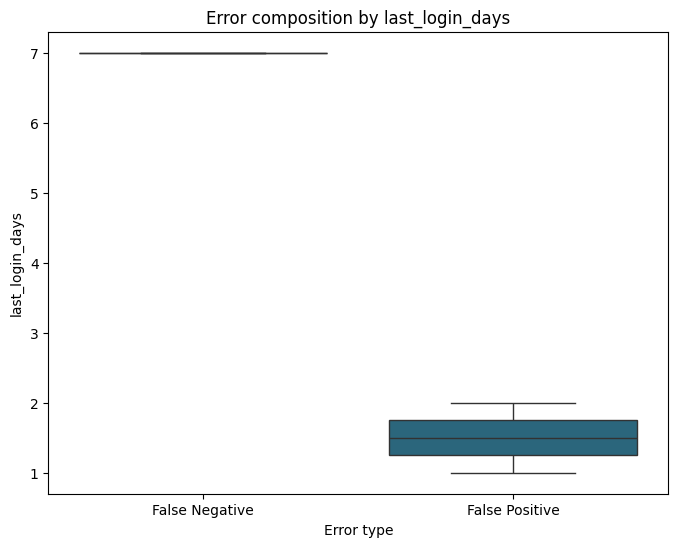

In [75]:
# visualize errors by numerical features 
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=errors_only_raw, x="error_type", y=col, palette="crest")
    plt.title(f"Error composition by {col}")
    plt.ylabel(col)
    plt.xlabel("Error type")
    plt.show()

Numerical error insights:

* The model seemed to struggle with:
    *   High log_watch__hours, high log_avg_watch_hours_per_day, recent activity/engagement (7 days)  |  False negative
    *   Low log_watch_hours, low log_avg_watch_hours_per_day, very recent activity/engagement (1-2 days)  |  False positives
    *   This largely makes sense sense due to heavy reliance on feature importance, however recent activity is interesting, possibly suggesting other factors

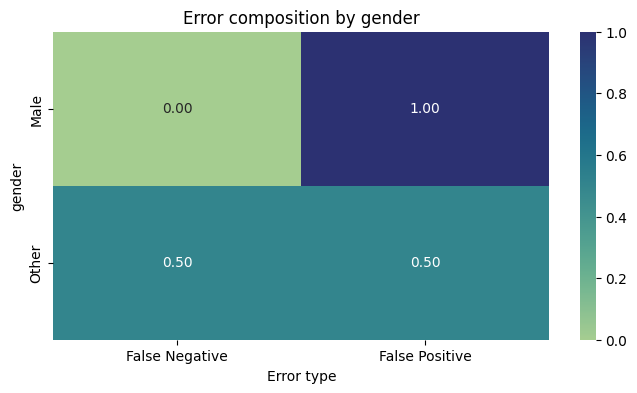

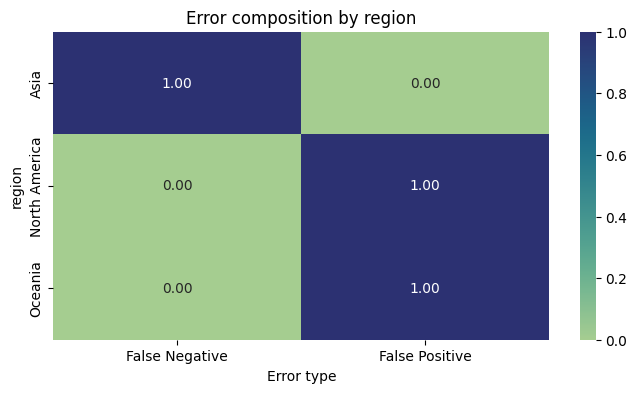

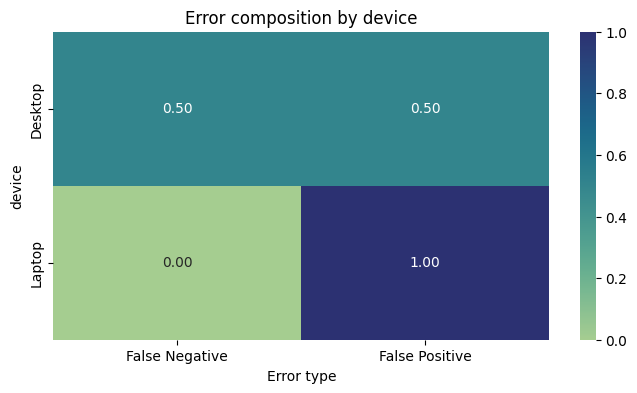

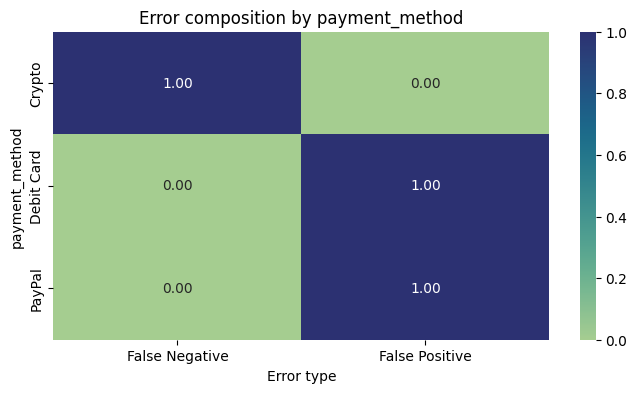

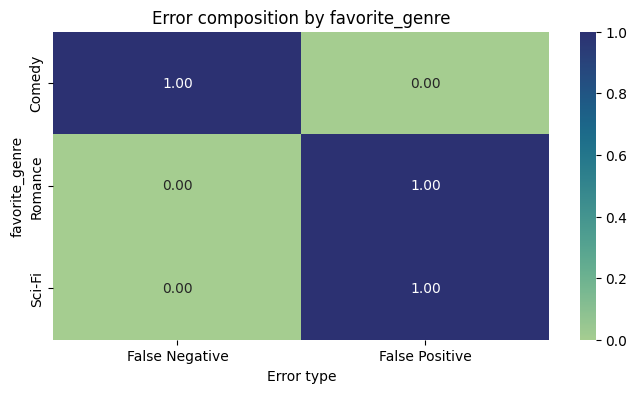

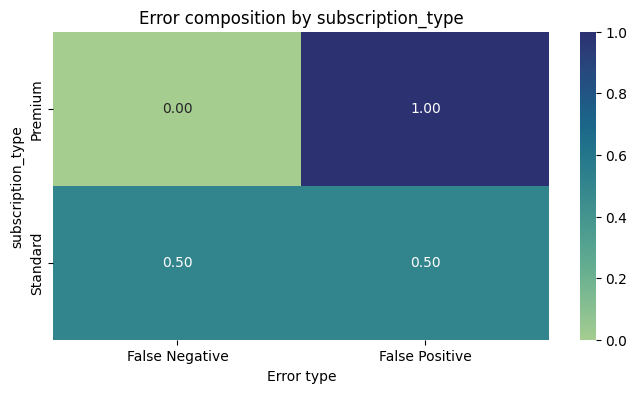

In [76]:
# visualize errors by categorical features  
for feature in cat_cols:
    ct = pd.crosstab(errors_only_cat[feature], errors_only_cat["error_type"], normalize="index")
    plt.figure(figsize=(8, max(4, len(ct) * 0.4)))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap="crest")
    plt.title(f"Error composition by {feature}")
    plt.ylabel(feature)
    plt.xlabel("Error type")
    plt.show()


Categorical error insights:

* The model seemed to struggle with:
    *   Accurate prediction using non-basic subscription types, which was previously shown 
    *   Accurate prediction using payment_method, despite high seperablilty with the 'crypto' and 'debit card' categories
    *   The latter seems to imply that other factors contributed to the classification, resulting in an edge case

In [77]:
# analyze how confidently wrong the model is
errors_only_raw.groupby("error_type")["y_proba"].describe()

,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
False Negative,1.0,0.465373,NaN,0.465373,0.465373,0.465373,0.465373,0.465373
False Positive,2.0,0.519088,0.011055,0.511271,0.515180,0.519088,0.522997,0.526905


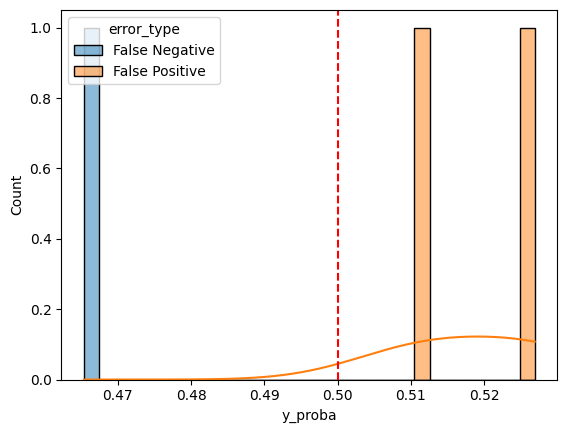

In [78]:
# plot the errors compared to the threshold
sns.histplot(data=errors_only_raw,x="y_proba",hue="error_type",bins=30,kde=True)
plt.axvline(0.5, color="red", linestyle="--")
plt.show()

Model confidence insights:

*  The model was fairly uncertain in it's predictions, with all errors being within +- .04 of the threshold
*  This suggests these were edge cases (confirmed above) that the model was struggling with
*  Model generalizes well

### Error Analysis insights:

Post-model error analysis examined false positives and false negatives to understand where the model struggled. Misclassifications were analyzed across both numeric and categorical dimensions, revealing patterns such as:

*  False negative(s) center around moderately engaged user rather than extreme (low engagement) cases, suggesting a subgroup of users who churn for reasons beyond simple inactivity.
*  False positives are more common among recently active users with declining engagement, indicating conservative recall-oriented behavior.
*  Certain subscription tiers and payment methods being overrepresented in prediction errors
*  Misclassifications often occurring at mid-range predicted probabilities rather than extreme confidence levels

These findings suggest opportunities for threshold tuning, feature interaction modeling, or targeted business interventions rather than purely model-centric fixes.

### Final Results and conclusions

This project developed and evaluated a supervised learning approach to customer churn prediction using a strict train/validation/test split, comprehensive exploratory analysis, and a production-aligned modeling workflow.

Key results include:

*  Exploratory analysis showed that churn is driven primarily by behavioral engagement and recency patterns, with watch activity, inactivity duration, and usage intensity emerging as consistent signals.
*  Feature selection and effect-size analysis confirmed meaningful relationships between engagement features and churn, while demographic variables exhibited limited standalone predictive power.
*  Multiple model families were evaluated using cross-validation and recall-oriented metrics. AdaBoost provided the strongest overall performance and was selected as the final model.
*  Hyperparameter tuning improved churn capture while maintaining acceptable precision, aligning model behavior with retention-focused decision priorities.
*  Final evaluation on the held-out test set demonstrated strong generalization, with high recall and ROC-AUC.

Error analysis indicated that remaining misclassifications occur primarily among moderately engaged users, rather than extreme inactivity cases, suggesting that future improvements would benefit more from behavioral segmentation or targeted retention strategies than increased model complexity.

### Save model:

In [79]:
import joblib
artifact = {
    "model": final_model,
    "features": X_trainval.columns.tolist(),
    "target": "churned",
    "threshold": 0.5,  
    "metrics": {
        "recall": test_recall,
        "roc_auc": test_roc_auc,
        "accuracy": test_accuracy,
        "precision": test_precision
    }
}

joblib.dump(artifact, "churn_adaboost_artifact.joblib")

['churn_adaboost_artifact.joblib']